## Intro and Purpose
This notebook look at AHF data and explore propensity to pay model 

In [76]:
## import
import os
import pandas as pd
from pandas import DataFrame as df
import calendar
import datetime

import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.cluster import KMeans

from sklearn import preprocessing, tree, svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer , OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn import metrics

from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import confusion_matrix
import numpy.ma as maf
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

os.chdir('C:/Users/binh/Dropbox (CareSkore)/Customer_data/AIDSHealth/Data/csv')

In [77]:
visits = pd.read_stata('wknCareSkoreVisits.dta')

In [78]:
visits.head()

,v1,fldpmppid,fldpatientvisitid,fldvisitdate,fldproccode,fldproccptcode,fldcptprocedurecodequalifiermid,fldprocdesc,flddiag,fldoriginsallocation,fldorigpatallocation,fldinsallocation,fldpatallocation,fldinspayment,fldpatpayment,fldinsadjustment,fldpatadjustment,fldinsbalance,fldpatbalance
0,38437,201470,29955,2009-04-07 00:00:00,99213,99213,152.0,Office or other outpatient visit for the evalu...,"780.93,042,V02.62",69.0,0.0,69.0,0.0,26.610001,0.0,42.389999,0.0,0.0,0.0
1,38462,201470,46058,2009-10-13 00:00:00,99214,99214,152.0,Office or other outpatient visit for the evalu...,"042,070.54,272.4",134.0,0.0,132.0,2.0,31.170000,0.0,100.830002,2.0,0.0,0.0
2,38488,201470,210198,2013-06-03 13:45:00,36415,36415,152.0,Collection of venous blood by venipuncture,"042,070.54,V70.0,721.42",10.0,0.0,10.0,0.0,0.000000,0.0,10.000000,0.0,0.0,0.0
3,38435,201470,28767,2009-03-23 00:00:00,90746,90746,152.0,"Hepatitis B vaccine, adult dosage, for intramu...","042,V02.62,V05.3",100.0,0.0,100.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0
4,38441,201470,44329,2009-09-16 00:00:00,90746,90746,152.0,"Hepatitis B vaccine, adult dosage, for intramu...","042,V05.3",100.0,0.0,100.0,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0


In [79]:
### summary statistics of allocation, payment, adjustment and balan
balance = ['fldoriginsallocation', 'fldorigpatallocation', 'fldinsallocation', 'fldpatallocation', 'fldinspayment', 'fldpatpayment',
           'fldinsadjustment', 'fldpatadjustment', 'fldinsbalance', 'fldpatbalance']

for x in balance:
    print('Summary statistics x: %s' %visits[x].describe())

Summary statistics x: count    38500.000000
mean        75.790848
std         74.569670
min          0.000000
25%         10.000000
50%         56.000000
75%        134.000000
max        720.000000
Name: fldoriginsallocation, dtype: float64
Summary statistics x: count    38500.000000
mean         3.423388
std         18.593332
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        359.000000
Name: fldorigpatallocation, dtype: float64
Summary statistics x: count    38500.000000
mean        75.114075
std         74.408117
min        -60.320000
25%         10.000000
50%         56.000000
75%        134.000000
max        720.000000
Name: fldinsallocation, dtype: float64
Summary statistics x: count    38500.000000
mean         4.100189
std         20.231975
min        -30.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        359.000000
Name: fldpatallocation, dtype: float64
Summary statistics x: count    38500.000000


### positive balance as not paying
- notes: there are potential issues with this approach. Positive balance only shows that patients don't pay balance immediately at the appoinment. They can still pay in full once bills are sent to their home and should NOT be considered as low propensity to pay.
- However, for outpatient clinics, especially AHF, it's often suggested that you pay your out-of-pocket portion upon leaving the clinic. Thus those with positive balance are those who will not probably pay their due. Especially when this is HIV/AIDS clinics in inner city Miami - many of those going there may not have a home, i.e., homeless. 
- Whether this indicator may work depend on the feature importance. If probability of not paying is highly influenced by previous not paying, it is suggestive that positive balance is a good indicator for not paying

In [80]:
## first we'll need to sort teh data :)
visits.sort_values(by=["fldpmppid","fldvisitdate"], ascending=True)


,v1,fldpmppid,fldpatientvisitid,fldvisitdate,fldproccode,fldproccptcode,fldcptprocedurecodequalifiermid,fldprocdesc,flddiag,fldoriginsallocation,fldorigpatallocation,fldinsallocation,fldpatallocation,fldinspayment,fldpatpayment,fldinsadjustment,fldpatadjustment,fldinsbalance,fldpatbalance
66,38439,201470,22980,2008-10-09 00:00:00,99204,99204,152.0,Office or other outpatient visit for the evalu...,"042,784.0,536.8,250.00",169.00,2.0,169.00,2.0,68.839996,2.0,100.160004,0.0,0.0,0.0
18,38438,201470,23321,2008-10-30 00:00:00,99214,99214,152.0,Office or other outpatient visit for the evalu...,042,100.00,2.0,102.00,0.0,41.459999,0.0,60.540001,0.0,0.0,0.0
15,38466,201470,23789,2008-11-19 00:00:00,99213,99213,152.0,Office or other outpatient visit for the evalu...,042,67.00,2.0,67.00,2.0,26.610001,2.0,40.389999,0.0,0.0,0.0
47,38467,201470,24134,2008-12-15 00:00:00,99213,99213,152.0,Office or other outpatient visit for the evalu...,"042,250.00",67.00,2.0,69.00,0.0,26.610001,0.0,42.389999,0.0,0.0,0.0
60,38487,201470,25200,2009-02-02 00:00:00,99214,99214,152.0,Office or other outpatient visit for the evalu...,"042,V02.62,786.59",0.00,102.0,0.00,102.0,0.000000,4.0,0.000000,98.0,0.0,0.0
34,38486,201470,27723,2009-03-02 00:00:00,99214,99214,152.0,Office or other outpatient visit for the evalu...,"042,786.59,V02.62",100.00,2.0,102.00,0.0,41.459999,0.0,60.540001,0.0,0.0,0.0
36,38433,201470,28514,2009-03-17 00:00:00,99214,99214,152.0,Office or other outpatient visit for the evalu...,"042,789.07,V02.62",100.00,2.0,102.00,0.0,41.459999,0.0,60.540001,0.0,0.0,0.0
3,38435,201470,28767,2009-03-23 00:00:00,90746,90746,152.0,"Hepatitis B vaccine, adult dosage, for intramu...","042,V02.62,V05.3",100.00,0.0,100.00,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0
5,38436,201470,28767,2009-03-23 00:00:00,99213,99213,152.0,Office or other outpatient visit for the evalu...,"042,V02.62,V05.3",67.00,2.0,67.00,2.0,24.610001,0.0,42.389999,2.0,0.0,0.0
12,38434,201470,28767,2009-03-23 00:00:00,90632,90632,152.0,"Hepatitis A vaccine, adult dosage, for intramu...","042,V02.62,V05.3",100.00,0.0,100.00,0.0,0.000000,0.0,100.000000,0.0,0.0,0.0


In [81]:
visits['nopay1'] = visits['fldpatbalance'].apply(lambda x : 1 if x > 0 else 0) 
visits['nopay2'] = visits['fldinsbalance'].apply(lambda x : 1 if x > 0 else 0) 

In [82]:
visits['nopay1'].describe()

count    38500.000000
mean         0.034753
std          0.183157
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: nopay1, dtype: float64

In [83]:
visits['nopay2'].describe()

count    38500.000000
mean         0.034779
std          0.183223
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: nopay2, dtype: float64

In [84]:
## lag values
visits['prior_nopay2'] = visits.groupby(['fldpmppid'])['nopay2'].shift(1)
visits['prior_nopay1'] = visits.groupby(['fldpmppid'])['nopay1'].shift(1)

In [85]:
visits['tot_nopay2'] = visits.groupby(['fldpmppid'])['prior_nopay2'].cumsum()
visits['tot_nopay1'] = visits.groupby(['fldpmppid'])['prior_nopay1'].cumsum()

In [86]:
print( 'Prior nopay 2: %s' %visits['prior_nopay2'].describe())
print( 'Prior nopay 1: %s' %visits['prior_nopay1'].describe())

Prior nopay 2: count    37618.000000
mean         0.033707
std          0.180477
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: prior_nopay2, dtype: float64
Prior nopay 1: count    37618.000000
mean         0.032910
std          0.178403
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: prior_nopay1, dtype: float64


In [87]:
print( 'Total nopay 1: %s' %visits['tot_nopay1'].describe())
print( 'Total nopay 2: %s' %visits['tot_nopay2'].describe())

Total nopay 1: count    37618.000000
mean         0.705301
std          1.473796
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         15.000000
Name: tot_nopay1, dtype: float64
Total nopay 2: count    37618.000000
mean         1.309453
std          4.019461
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         78.000000
Name: tot_nopay2, dtype: float64


In [88]:
## total appoinment
visits['appointment']=1
visits['tot_appt'] = visits.groupby(['fldpmppid'])['appointment'].cumsum()
print( 'Total appoinment: %s' %visits['tot_appt'].describe())

Total appoinment: count    38500.000000
mean        38.915377
std         33.318474
min          1.000000
25%         13.000000
50%         31.000000
75%         56.000000
max        273.000000
Name: tot_appt, dtype: float64


In [89]:
visits['perc_nopay1'] = visits['tot_nopay1']/visits['tot_appt'] 
visits['perc_nopay2'] = visits['tot_nopay2']/visits['tot_appt'] 

In [90]:
print( 'Percertage nopay 1: %s' %visits['perc_nopay1'].describe())
print( 'Percertage nopay 2: %s' %visits['perc_nopay2'].describe())

Percertage nopay 1: count    37618.000000
mean         0.025925
std          0.067773
min          0.000000
25%          0.000000
50%          0.000000
75%          0.021978
max          0.875000
Name: perc_nopay1, dtype: float64
Percertage nopay 2: count    37618.000000
mean         0.027891
std          0.058903
min          0.000000
25%          0.000000
50%          0.000000
75%          0.037037
max          0.857143
Name: perc_nopay2, dtype: float64


In [91]:
## rename variable to match with AHF original data
visits = visits.rename(columns = {"fldpatientvisitid" : "fldPatientVisitID" })
visits = visits.rename(columns = {"fldpmppid" : "fldPMPPID" })

In [92]:
print('AHF shape: {}'.format(ahf.shape))
print('Visits shape: {}'.format(visits.shape))

AHF shape: (77704, 82)
Visits shape: (38500, 29)


In [93]:
visits.head()
print('number of unique visits: %s' %visits['fldPatientVisitID'].nunique())
print('number of unique visitors: %s' %visits['fldPMPPID'].nunique())

number of unique visits: 24288
number of unique visitors: 882


In [94]:
ahf = pd.read_pickle('ahf_v1.p')

In [95]:
ahf.head()
print('number of unique visits: {}'.format(ahf['fldAppointmentsID'].nunique()))
print('number of unique visitors: {}'.format(ahf['fldPMPPID'].nunique()))

number of unique visits: 77704
number of unique visitors: 1157


Since the first attempt to merge visits and appoinment files are unsuccessful (assuming appoinment ID are the same as patientvisit ID and they are not), we are moving to second attempt by matching on dates for both visits and appoinment. 

Another approach to match the pmppid and date with original AHF data but that causes problems as well - too many missing values for the pay - no pay variables (our main target)

Now move on to whether to match patientID with patientvisitID

In [96]:
## date and time for AHF
ahf['fldApptStart'] = pd.to_datetime(ahf['fldApptStart'],  errors='coerce')

## try to sort by patientID and then by encounterdatetime
ahf.sort_values(by=["fldPMPPID","fldApptStart"], ascending=True)
ahf['date'] = ahf['fldApptStart'].dt.date

In [97]:
## date and time for visits
visits['fldvisitdate'] = pd.to_datetime(visits['fldvisitdate'],  errors='coerce')

## try to sort by patientID and then by encounterdatetime
visits.sort_values(by=["fldPMPPID","fldvisitdate"], ascending=True)
visits['date'] = visits['fldvisitdate'].dt.date

In [98]:
## import patients file 
patients = pd.read_stata('wknCareSkorePatients.dta')

In [99]:
patients = patients.rename(columns = {"fldpmppid" : "fldPMPPID" })

In [100]:
## merge two dataset
ahf_visit= pd.merge(patients, visits , on = ['fldPMPPID'])

In [101]:
print('Visits & ahf: {}'.format(ahf_visit.shape))

Visits & ahf: (38500, 57)


In [102]:
ahf_visit

,v1_x,fldpmpatientid,fldPMPPID,fldemrppid,fldpmfacilityid,fldpmpcpid,fldpname,fldage,fldbirthdate,flddeathdate,...,nopay2,prior_nopay2,prior_nopay1,tot_nopay2,tot_nopay1,appointment,tot_appt,perc_nopay1,perc_nopay2,date
0,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,NaN,NaN,NaN,NaN,1,1,NaN,NaN,2009-04-07
1,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,2,0.000000,0.0,2009-10-13
2,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,3,0.000000,0.0,2013-06-03
3,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,4,0.000000,0.0,2009-03-23
4,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,5,0.000000,0.0,2009-09-16
5,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,6,0.000000,0.0,2009-03-23
6,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,7,0.000000,0.0,2010-05-28
7,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,8,0.000000,0.0,2010-09-13
8,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,9,0.000000,0.0,2013-04-23
9,1046,201470,201470,1.537206e+15,152,152,"WELCH, JOE L",66,1950-02-02,NaN,...,0,0.0,0.0,0.0,0.0,1,10,0.000000,0.0,2015-01-27


###  DATA CLEANING
- ahf_visit is the final dataset
- We'll clean the data similar to noshow/cancelation model

In [103]:
ahf_visit['visit_year'] = ahf_visit['fldvisitdate'].dt.year
ahf_visit['visit_month'] = ahf_visit['fldvisitdate'].dt.month
ahf_visit['visit_day'] = ahf_visit['fldvisitdate'].dt.day
ahf_visit['visit_hour'] = ahf_visit['fldvisitdate'].dt.hour

ahf_visit['visit_year'].describe()

count    38500.000000
mean      2013.085429
std          1.982468
min       2008.000000
25%       2012.000000
50%       2013.000000
75%       2015.000000
max       2016.000000
Name: visit_year, dtype: float64

In [152]:
ahf_visit['female'] = ahf_visit['fldsex'].apply(lambda x : +1 if x=="F" else 0) 

ahf_visit['white'] = ahf_visit['fldrace'].apply(lambda x : +1 if x=="White" or x== "NaN" else 0)   ## we need to assign missing to the largest category
ahf_visit['black'] = ahf_visit['fldrace'].apply(lambda x : +1 if x=="Black/African American" else 0) 
ahf_visit['other_race'] = ahf_visit['fldrace'].apply(lambda x : 0 if x=="White" or x=="Black/African American"  else 1) 

In [153]:
# Income
ahf_visit['poor'] = ahf_visit['fldincomelevel'].apply(lambda x : +1 if x=="Below 100% of the Federal Poverty Level" or x== "100-138% of the Federal Poverty Level" or x=="Unknown" or x=="Unreported" else 0)   ## we need to assign missing to the largest category
ahf_visit['middle'] = ahf_visit['fldincomelevel'].apply(lambda x : +1 if x=="139-200% of the Federal Poverty Level" or x== "201-250% of the Federal Poverty Level" else 0) 
ahf_visit['rich'] = ahf_visit['fldincomelevel'].apply(lambda x : +1 if x=="251-300% of the Federal Poverty Level" or x=="301-400% of the Federal Poverty Level" or x== "401-500% of the Federal Poverty Level" or x== "More than 500% of the Federal Poverty.." else 0) 

# Employment status
ahf_visit['unemployed'] = ahf_visit['fldemploymentstatus'].apply(lambda x : +1 if x=="Unemployed" or x== "" else 0)   ## we need to assign missing to the largest category
ahf_visit['employed'] = ahf_visit['fldemploymentstatus'].apply(lambda x : +0 if x=="Unemployed" or x== "" else 1) 

In [154]:
ahf_visit.columns

Index(['v1_x', 'fldpmpatientid', 'fldPMPPID', 'fldemrppid', 'fldpmfacilityid',
       'fldpmpcpid', 'fldpname', 'fldage', 'fldbirthdate', 'flddeathdate',
       'fldrace', 'fldsex', 'fldemploymentstatus', 'fldincomelevel',
       'fldphones', 'fldaddress1', 'fldaddress2', 'fldcity', 'fldstate',
       'fldzip', 'fldprimaryins', 'fldprimaryinsid',
       'fldprimaryinseffectivedate', 'fldprimaryinsterminationdate',
       'fldsecondaryins', 'fldsecondaryinsid', 'fldsecondaryinseffectivedate',
       'fldsecondaryinsterminationdate', 'v1_y', 'fldPatientVisitID',
       'fldvisitdate', 'fldproccode', 'fldproccptcode',
       'fldcptprocedurecodequalifiermid', 'fldprocdesc', 'flddiag',
       'fldoriginsallocation', 'fldorigpatallocation', 'fldinsallocation',
       'fldpatallocation', 'fldinspayment', 'fldpatpayment',
       'fldinsadjustment', 'fldpatadjustment', 'fldinsbalance',
       'fldpatbalance', 'nopay1', 'nopay2', 'prior_nopay2', 'prior_nopay1',
       'tot_nopay2', 'tot_nopay1'

In [155]:
## date and time
ahf_visit['fldbirthdate'] = pd.to_datetime(ahf_visit['fldbirthdate'],  errors='coerce')
ahf_visit['birth_year'] = ahf_visit['fldbirthdate'].dt.year
ahf_visit['birth_month'] = ahf_visit['fldbirthdate'].dt.month
ahf_visit['birth_day'] = ahf_visit['fldbirthdate'].dt.day

# Age group
ahf_visit['Age'] = ahf_visit['visit_year'].sub(ahf_visit['birth_year'],axis=0)
print ('Age description: {}'.format(ahf_visit['Age'].describe()))
print('Birth year description: {}'.format(ahf_visit['birth_year'].describe()))

Age description: count    38500.000000
mean        47.835065
std         11.909050
min         18.000000
25%         40.000000
50%         49.000000
75%         56.000000
max         85.000000
Name: Age, dtype: float64
Birth year description: count    38500.000000
mean      1965.250364
std         12.006617
min       1930.000000
25%       1957.000000
50%       1964.000000
75%       1973.000000
max       1997.000000
Name: birth_year, dtype: float64


In [156]:
# AM / PM
ahf_visit['visit_AM'] = ahf_visit['visit_hour'].apply(lambda x : +1 if x<12 else 0) 

# winter/summer
ahf_visit['visit_winter'] = ahf_visit['visit_month'].apply(lambda x : +1 if x>8 or x<4  else 0) 

In [157]:
## age group
ahf_visit['age_30'] = ahf_visit['Age'].apply(lambda x : +1 if x<30 else 0)
ahf_visit['age_40'] = ahf_visit['Age'].apply(lambda x : +1 if x<40  and x>29 else 0)
ahf_visit['age_50'] = ahf_visit['Age'].apply(lambda x : +1 if x<50  and x>39 else 0)
ahf_visit['age_65'] = ahf_visit['Age'].apply(lambda x : +1 if x>50 else 0)

In [158]:
print ('age_30 description: {}'.format(ahf_visit['age_30'].astype(int).describe()))
print ('age_40 description: {}'.format(ahf_visit['age_40'].astype(int).describe()))
print ('age_50 description: {}'.format(ahf_visit['age_50'].astype(int).describe()))
print ('age_65 description: {}'.format(ahf_visit['age_65'].astype(int).describe()))

age_30 description: count    38500.000000
mean         0.096779
std          0.295661
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: age_30, dtype: float64
age_40 description: count    38500.000000
mean         0.148545
std          0.355644
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: age_40, dtype: float64
age_50 description: count    38500.000000
mean         0.260805
std          0.439080
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: age_50, dtype: float64
age_65 description: count    38500.000000
mean         0.453065
std          0.497799
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: age_65, dtype: float64


### DATA EXPLORATORY AND VISUALIZATION
- Age distribution
- Primary Health insurance 20 most popular insurers
- % of available secondary health insurers (dummy variable 2nd insurer availability)
- Percentage of no-pay by year (seem to be a very important factor???)

In [159]:
age_df = pd.DataFrame()
age_df['Count'] = ahf_visit['fldage'].value_counts()
age_df['Age'] = age_df.index
age_df.head()

,Count,Age
52,2474,52
55,1872,55
50,1694,50
51,1638,51
58,1547,58


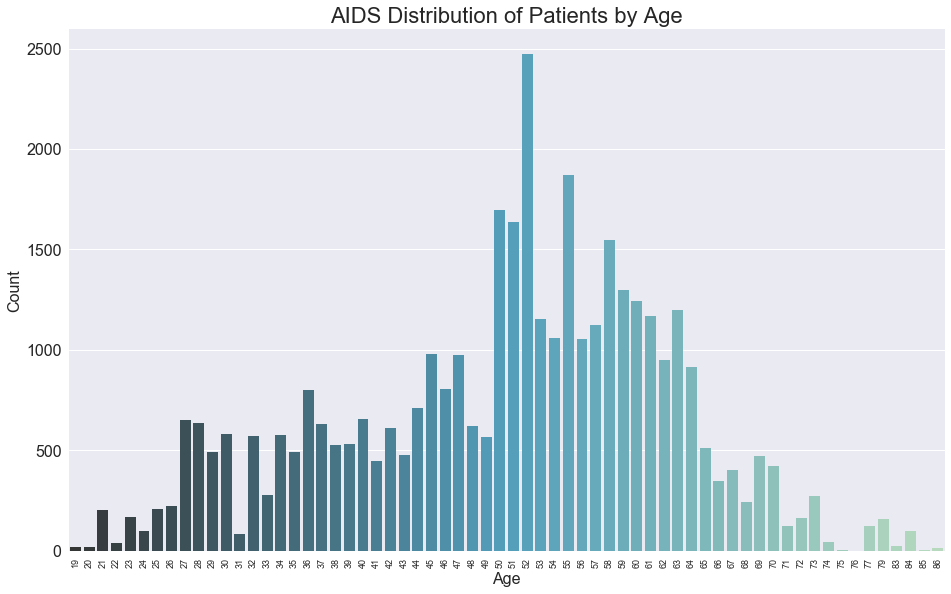

In [160]:
a4_dims = (15.7, 9.6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(x='Age', y='Count', data=age_df, palette='GnBu_d')
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=16)
plt.title('AIDS Distribution of Patients by Age', fontsize=22)
plt.xlabel('Age', fontsize=16)
plt.ylabel('Count', fontsize=16)

In [161]:
ins_count_df = pd.DataFrame()
ins_count_df['Count'] = ahf_visit['fldprimaryins'].value_counts()
ins_count_df['Insurer'] = ins_count_df.index
ins_count_df.head()

,Count,Insurer
POSITIVE HEALTHCARE PARTNERS,10603,POSITIVE HEALTHCARE PARTNERS
POSITIVE HEALTHCARE,9840,POSITIVE HEALTHCARE
Medicare Florida,4648,Medicare Florida
Ryan White Miami,2881,Ryan White Miami
UNITED HEALTHCARE,976,UNITED HEALTHCARE


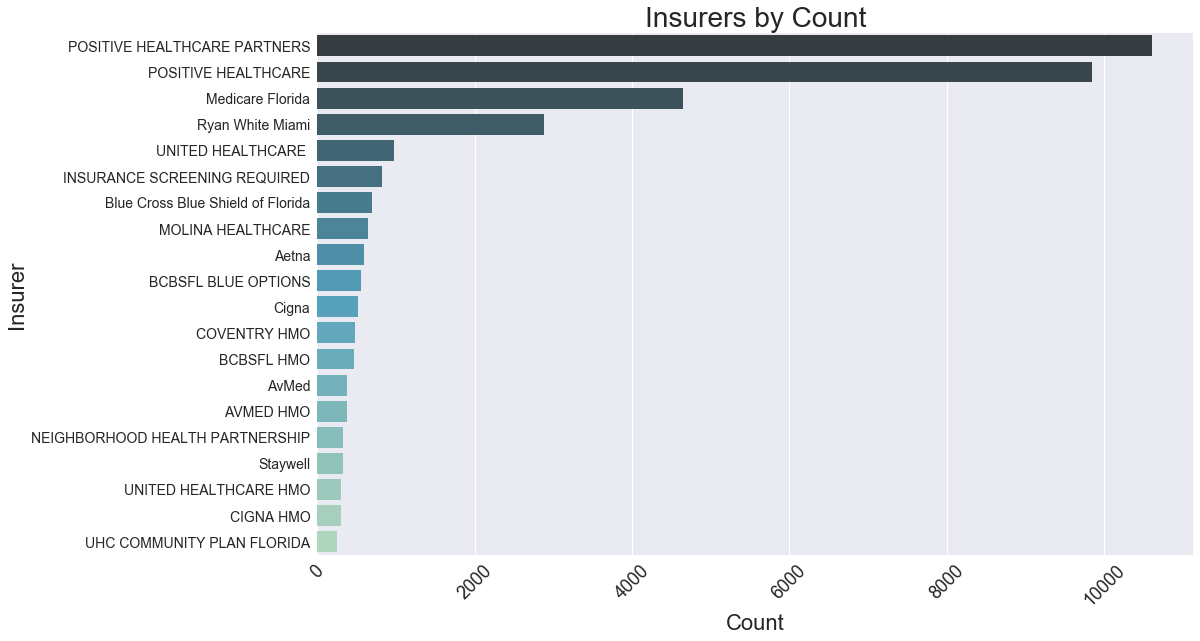

In [162]:
a4_dims = (15.7, 9.6)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(y='Insurer', x='Count', data=ins_count_df.iloc[:20,:], palette='GnBu_d')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=14)
plt.title('Insurers by Count', fontsize=28)
plt.ylabel('Insurer', fontsize=22)
plt.xlabel('Count', fontsize=22)

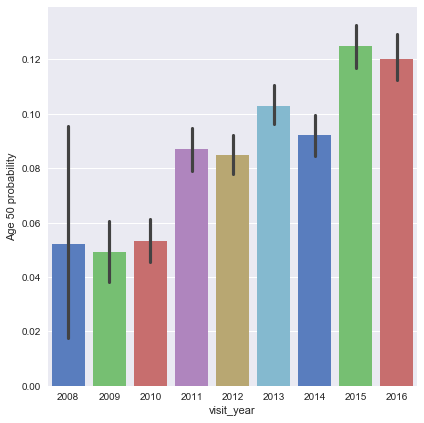

In [163]:
## percentage of no-pay by year
## first, create a new dataframe for annual nopay
g = sns.factorplot(x="visit_year", y="age_30", data=ahf_visit,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Age 50 probability")

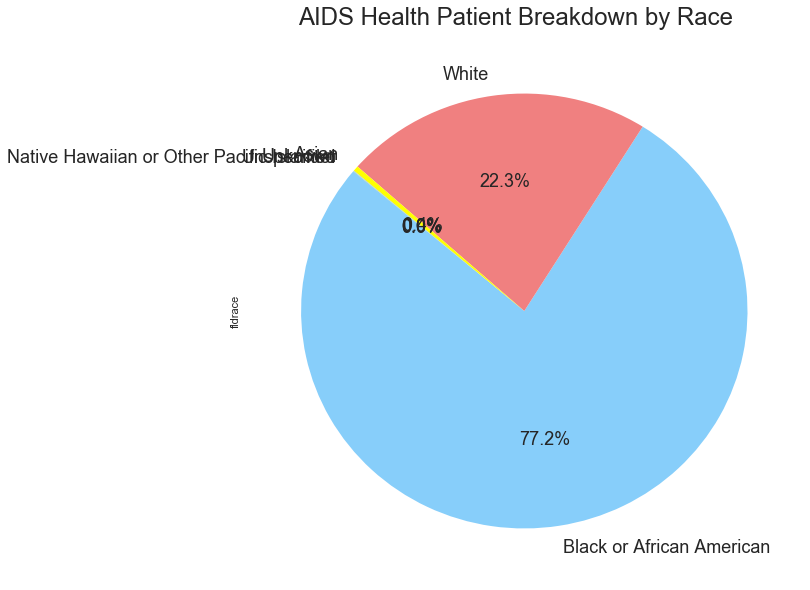

In [164]:
plt.figtext(.5,.9,'AIDS Health Patient Breakdown by Race', fontsize=24, ha='center')
ahf_visit['fldrace'].value_counts().plot(colors=['lightskyblue', 'lightcoral', 'yellow'],startangle=140,autopct='%1.1f%%',kind='pie',
                                         figsize=(10, 10), fontsize=18)

In [165]:
StringList = ahf_visit['fldprimaryins']
Contain = lambda StringList, SubString: StringList.str.lower().str.contains(SubString.lower())

IsMedicare = Contain(StringList, 'Medicare')
IsMedicaid = Contain(StringList, 'Medicaid')
IsSelf = StringList.isnull() | Contain(StringList, 'SELF PAY (SELF)')
IsPrivate = -(IsMedicare | IsMedicaid | IsSelf)

ahf_visit['medicare']    =   IsMedicare.convert_objects(convert_numeric=True)
ahf_visit['medicaid']    =   IsMedicaid.convert_objects(convert_numeric=True)
ahf_visit['private'] =   IsPrivate.convert_objects(convert_numeric=True)
ahf_visit['selfpay'] =   IsSelf.convert_objects(convert_numeric=True)

C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  from ipykernel import kernelapp as app
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.

In [166]:
## secondary health insurance
ahf_visit['second_insurer'] = ahf_visit['fldsecondaryins'].apply(lambda x : 0 if x == '' else 1)
ahf_visit['second_insurer'].describe()

count    38500.000000
mean         0.231948
std          0.422081
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: second_insurer, dtype: float64

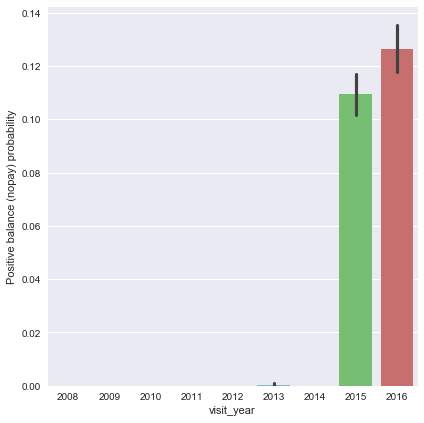

In [167]:
g = sns.factorplot(x="visit_year", y="nopay1", data=ahf_visit,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Positive balance (nopay) probability")

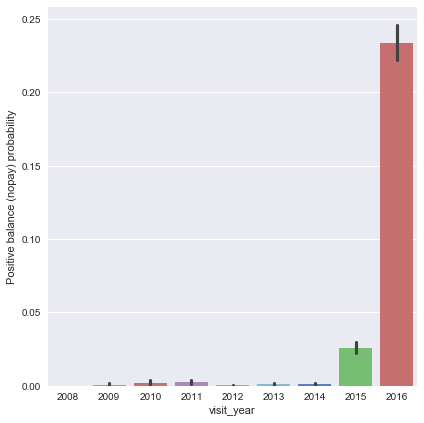

In [168]:
g = sns.factorplot(x="visit_year", y="nopay2", data=ahf_visit,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Positive balance (nopay) probability")

### note:
Since positive balance is only happened in 2015-2016, we'll restrict our sample to this 2 years only. 
We don't know exactly why there are no positive balances in previous year (probably they apply for debt forgiveness???) 

It's also clear from the graph that nopay1 is a better pick than nopay2 since nopay1 has similar probability in 2015-2016 whereas nopay2 has very low probability in 2015 compared to that of 2016. 

In [169]:
ahf_visit_small = ahf_visit[ahf_visit['visit_year']>2014 ]

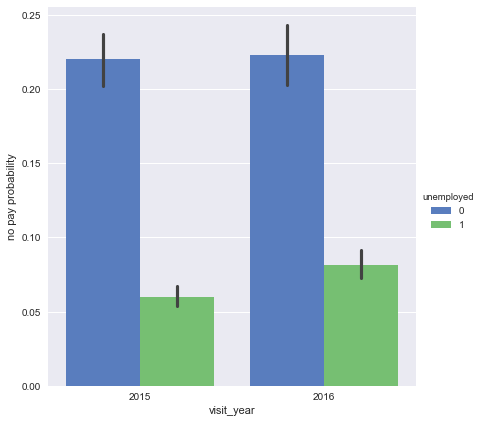

In [170]:
# Draw a nested barplot
g = sns.factorplot(x="visit_year", y="nopay1", hue="unemployed", data=ahf_visit_small,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("no pay probability")

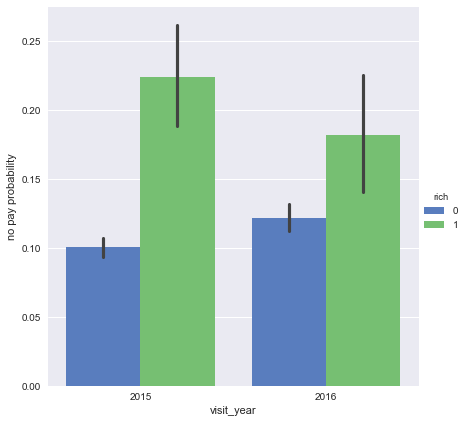

In [171]:
g = sns.factorplot(x="visit_year", y="nopay1", hue="rich", data=ahf_visit_small,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("no pay probability")

In [172]:
ahf_visit_small['employed'].describe()

count    11447.000000
mean         0.311610
std          0.463172
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: employed, dtype: float64

In [173]:
ahf_visit_small['nopay1'].describe()

count    11447.000000
mean         0.116624
std          0.320986
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: nopay1, dtype: float64

In [174]:
print ('medicare description: {}'.format(ahf_visit['medicare'].astype(int).describe()))
print ('medicaid description: {}'.format(ahf_visit['medicaid'].astype(int).describe()))
print ('private description: {}'.format(ahf_visit['private'].astype(int).describe()))
print ('selfpay description: {}'.format(ahf_visit['selfpay'].astype(int).describe()))

medicare description: count    38500.000000
mean         0.127481
std          0.333515
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: medicare, dtype: float64
medicaid description: count    38500.000000
mean         0.015455
std          0.123354
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: medicaid, dtype: float64
private description: count    38500.000000
mean         0.857065
std          0.350011
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: private, dtype: float64
selfpay description: count    38500.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: selfpay, dtype: float64


In [175]:
## transform medicaid medicare variable (string) to dummy variable
ahf_visit['medicare'] = ahf_visit['medicare'].astype(int)
ahf_visit['medicaid'] = ahf_visit['medicaid'].astype(int)
ahf_visit['private'] = ahf_visit['private'].astype(int)

In [176]:
### export data to csv filea
ahf_visit.to_csv('ahf_visit.csv')

## MODELLING STARTS HERE

In [177]:
target = 'nopay1'
features = ['female' , 
            'age_30', 'age_40', 'age_50', 'age_65',                 
            'black',  'white', 'other_race',                        
            'perc_nopay1' ,
            'medicare', 'medicaid', 'private', 'selfpay',
            'visit_AM', 'visit_winter', 
             'middle' , 'poor', 'rich',
             'unemployed', 
          #  'visit_year',
            'second_insurer'
           ]

In [178]:
NRow = ahf_visit_small.shape[0]
Fraction = 0.9    # meaning the training sample is 90% of total sample, testing sample is 10%
np.random.seed(123)        # Setting the random seed
NTrain = int(round(NRow*Fraction))
IndexTrain = np.random.choice(np.arange(NRow), NTrain, replace=False)
Final_Train = ahf_visit_small.loc[IndexTrain]
Final_Test = ahf_visit_small.drop(ahf_visit_small.index[IndexTrain])

XTrain = Final_Train[features]
YTrain = Final_Train[target]

XTest = Final_Test[features]
YTest = Final_Test[target]
 
imp = Imputer(missing_values='NaN', strategy="mean")
            
XTrain_Imp = imp.fit_transform(XTrain)
YTrain_Imp = imp.fit_transform(YTrain.reshape(-1, 1)).ravel().astype(int)   

XTest_Imp = imp.fit_transform(XTest)
YTest_Imp = imp.fit_transform(YTest.reshape(-1, 1)).ravel().astype(int)

C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\Users\binh\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


### Logistic Regression

In [179]:
## Logistic regression
nopay1_logistic = LogisticRegression()
nopay1_logistic.fit(XTrain_Imp, YTrain_Imp)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [180]:
from sklearn import metrics
## predict Yhat
LogitPred = nopay1_logistic.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_logit= metrics.roc_auc_score(YTest_Imp, LogitPred)
print('Nopay1 logistic regression ROC: %s ' %auc_logit)

Nopay1 logistic regression ROC: 0.704433497537 


In [181]:
# export the coefficient
logit_export = pd.DataFrame()
logit_export['feature'] = XTest.columns.values
logit_export['coef'] = nopay1_logistic.coef_.flatten()
print(logit_export)

print('intercept: %s' %nopay1_logistic.intercept_)

           feature      coef
0           female  1.359231
1           age_30 -0.318506
2           age_40 -3.081783
3           age_50  0.163701
4           age_65  0.180225
5            black  0.000000
6            white  0.726855
7       other_race -1.033733
8      perc_nopay1  3.058074
9         medicare  1.511960
10        medicaid -0.549083
11         private -1.269754
12         selfpay  0.000000
13        visit_AM -0.163520
14    visit_winter -0.467568
15          middle -0.171061
16            poor -0.149463
17            rich  0.013646
18      unemployed -2.022270
19  second_insurer -4.352414
intercept: [-0.30687772]


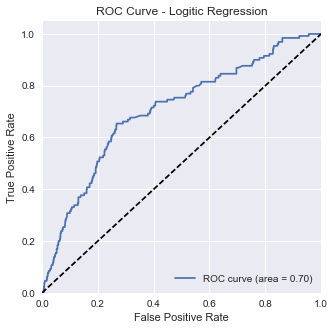

In [182]:
## graph the AUC curve
### drawing area under the curve
Ypred_logit = nopay1_logistic.predict_proba(XTest_Imp)[:, 1]

fpr, tpr, thresholds = roc_curve(YTest_Imp, Ypred_logit, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logitic Regression')
plt.legend(loc="lower right")
plt.show()

#### Note: 
- Since the logistic result are reasonable we'll stick with it for now
- The main problem is that the coefficients' signs are counter-intuitive. We'll explore whether it is the case and if it is, why?

### Random forest

In [183]:
nopay1_forest = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10,       # change here, from None
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, oob_score=False, 
                                n_jobs=1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None)
    
nopay1_forest.fit(XTrain_Imp, YTrain_Imp)

## predict Yhat
ForestPred = nopay1_forest.predict_proba(XTest_Imp)[:,1]

In [184]:
# area under the curve
auc_rf= metrics.roc_auc_score(YTest_Imp, ForestPred )
print('Area under the curve %s' %auc_rf)

Area under the curve 0.769689276241


In [185]:
# Build a forest and compute the feature importances
importances = nopay1_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in nopay1_forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

FeatureRanking = pd.DataFrame(features, columns=['Feature'])
FeatureRanking['Importance'] = importances
FeatureRanking = FeatureRanking.loc[indices]
print(FeatureRanking)

           Feature  Importance
8      perc_nopay1    0.521939
18      unemployed    0.066628
14    visit_winter    0.057172
19  second_insurer    0.046690
13        visit_AM    0.042017
10        medicaid    0.027364
0           female    0.024707
2           age_40    0.024158
15          middle    0.023775
3           age_50    0.021531
16            poor    0.021271
7       other_race    0.021108
6            white    0.021057
4           age_65    0.019620
11         private    0.017219
17            rich    0.016401
1           age_30    0.015085
9         medicare    0.012259
12         selfpay    0.000000
5            black    0.000000


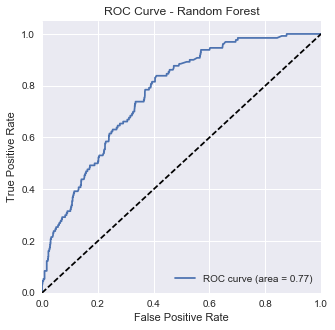

In [186]:
### drawing area under the curve
Ypred_forest = nopay1_forest.predict_proba(XTest_Imp)[:, 1]

fpr, tpr, thresholds = roc_curve(YTest_Imp, Ypred_forest, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

### Gradient Boosting

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'n_estimators': 150, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 3, 'random_state': 3}
nopay1_gbt = GradientBoostingClassifier(**params)
nopay1_gbt.fit(XTrain_Imp, YTrain_Imp)

## predict Yhat
GBT_Pred = nopay1_gbt.predict_proba(XTest_Imp)[:,1]

In [79]:
# area under the curve
auc_gbt= metrics.roc_auc_score(YTest_Imp, GBT_Pred )
print('Area under the curve %s' %auc_gbt)

Area under the curve 0.775308829102


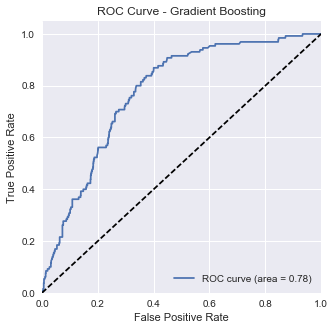

In [80]:
## graph area under the curve
GBT_Pred = nopay1_gbt.predict_proba(XTest_Imp)[:,1]

fpr, tpr, thresholds = roc_curve(YTest_Imp, GBT_Pred, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

### Gradient Boosting and Cross-validation

In [423]:
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [1,3,5], 'min_samples_leaf': [1,3,5], 'n_estimators': [10, 50, 100, 150, 250] }
ind_params = {'learning_rate': 0.5,'subsample': 0.8}


nopay1_gbt = GridSearchCV(GradientBoostingClassifier(**ind_params), 
                            cv_params, 
                            scoring = 'roc_auc', cv = 5, n_jobs = -1) 

nopay1_gbt.fit(XTrain_Imp, YTrain_Imp)

nopay1_gbt.grid_scores_
  
print('Best score: %s' %nopay1_gbt.best_score_)
print('Best parameters: %s' %nopay1_gbt.best_params_)

Best score: 0.934276199936
Best parameters: {'n_estimators': 50, 'min_samples_leaf': 1, 'max_depth': 3}


C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [424]:
gbt_pred = nopay1_gbt.predict(XTest_Imp)
gbt_pred_train = nopay1_gbt.predict(XTrain_Imp)

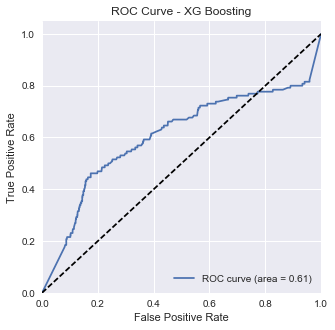

In [425]:
## graph area under the curve
GBT_Pred = nopay1_gbt.predict_proba(XTest_Imp)[:,1]

fpr, tpr, thresholds = roc_curve(YTest_Imp, GBT_Pred, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

### XGBoosting

In [385]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5], 'n_estimators': [10, 50, 100, 200]}
ind_params = {'learning_rate': 0.5, 'seed':0, 'subsample': 0.8, 
             }
nopay1_xgb = GridSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                            scoring = 'roc_auc', cv = 5, n_jobs = -1) 

nopay1_xgb.fit(XTrain_Imp, YTrain_Imp)

nopay1_xgb.grid_scores_
  
print('Best score: %s' %nopay1_xgb.best_score_)
print('Best parameters: %s' %nopay1_xgb.best_params_)

Best score: 0.964443188863
Best parameters: {'min_child_weight': 5, 'n_estimators': 10, 'max_depth': 5}


C:\Users\binh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [386]:
xgb_pred = nopay1_xgb.predict(XTest_Imp)
xgb_pred_train = nopay1_xgb.predict(XTrain_Imp)

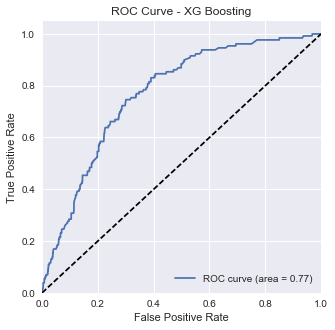

In [387]:
## graph area under the curve
GBT_Pred = nopay1_xgb.predict_proba(XTest_Imp)[:,1]

fpr, tpr, thresholds = roc_curve(YTest_Imp, GBT_Pred, pos_label=1);
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' %roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XG Boosting')
plt.legend(loc="lower right")
plt.show()

In [388]:
# area under the curve
auc_xgb= metrics.roc_auc_score(YTest_Imp, GBT_Pred )
print('Area under the curve %s' %auc_xgb)

Area under the curve 0.769018567639


### Regular XGboost without cross-validation -- why the results after CV is so dissapointing???

In [428]:
import xgboost as xgb

params = {'n_estimators': 10, 'min_child_weight': 5, 'max_depth': 5, 'subsample': 0.8,
          'learning_rate': 0.5, 'seed':0 }
nopay1_xgb1 = xgb.XGBClassifier(**params)
nopay1_xgb1.fit(XTrain_Imp, YTrain_Imp)

## predict Yhat
GGB1_Pred = nopay1_xgb1.predict_proba(XTest_Imp)[:,1]

In [429]:
# area under the curve
auc_xgb1= metrics.roc_auc_score(YTest_Imp, GGB1_Pred )
print('Area under the curve %s' %auc_xgb1)

Area under the curve 0.769018567639


## Dealing with unbalanced sample
paper is here: http://www.jmlr.org/papers/volume18/16-365/16-365.pdf

python module: https://github.com/scikit-learn-contrib/imbalanced-learn

The re-sampling techniques are implemented in four different categories: undersampling the majority class, oversampling the minority class, combining over and under sampling, and ensembling sampling.

Below is a list of the methods currently implemented in this module.

####  Under-sampling
- Random majority under-sampling with replacement
- Extraction of majority-minority Tomek links [1]
- Under-sampling with Cluster Centroids
- NearMiss-(1 & 2 & 3) [2]
- Condensend Nearest Neighbour [3]
- One-Sided Selection [4]
- Neighboorhood Cleaning Rule [5]
- Edited Nearest Neighbours [6]
- Instance Hardness Threshold [7]
- Repeated Edited Nearest Neighbours [14]
- AllKNN [14]

#### Over-sampling
https://github.com/scikit-learn-contrib/imbalanced-learn/wiki/Over-sampling
- Random minority over-sampling with replacement
- SMOTE - Synthetic Minority Over-sampling Technique [8]
- bSMOTE(1 & 2) - Borderline SMOTE of types 1 and 2 [9]
- SVM SMOTE - Support Vectors SMOTE [10]
- ADASYN - Adaptive synthetic sampling approach for imbalanced learning [15]

#### Over-sampling followed by under-sampling
- SMOTE + Tomek links [12]
- SMOTE + ENN [11]
- Ensemble sampling
- EasyEnsemble [13]
- BalanceCascade [13]

The different algorithms are presented in the sphinx-gallery.

###  Undersample method 

In [82]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import EditedNearestNeighbours

C:\Users\binh\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### UNDERSAMPLING -  randomundersampler method

In [86]:
# Generate the new dataset using under-sampling method
verbose = False

# 'Random under-sampling'  -- fit the new model to 
undersample = RandomUnderSampler()
usx, usy = undersample.fit_sample(XTrain_Imp, YTrain_Imp)
usx_t, usy_t = undersample.fit_sample( XTest_Imp, YTest_Imp )

In [87]:
## let's go random forest since it's the best performing model so far....
nopay_us_forest = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10,       # change here, from None
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, oob_score=False, 
                                n_jobs=1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None)
    
nopay_us_forest.fit(usx, usy)

## predict Yhat
ForestPred_US = nopay_us_forest.predict_proba(XTest_Imp)[:,1]

In [88]:
# area under the curve
auc_rf_us= metrics.roc_auc_score(YTest_Imp, ForestPred_US )
print('Area under the curve - UNDER SAMPLING: %s' %auc_rf_us)

Area under the curve - UNDER SAMPLING: 0.727658203865


#### UNDERSAMPLING - Tomek links

In [89]:
TL = TomekLinks()
tlx, tly = TL.fit_sample(XTrain_Imp, YTrain_Imp)

### RANDOM FOREST with tomek method #######
nopay_us_tl = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10,       # change here, from None
                               )

nopay_us_tl = nopay_us_tl.fit(tlx, tly)

In [90]:
## predict Yhat
ForestPred_TL = nopay_us_tl.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_us= metrics.roc_auc_score(YTest_Imp, ForestPred_TL )
print('Area under the curve - UNDER SAMPLING - Tomek links: %s' %auc_rf_us)

Area under the curve - UNDER SAMPLING - Tomek links: 0.789162561576


In [91]:
### Since Tomek link perform quite well (on par with Random forest from unbalanced sample), we look at logistic coefficients to see if it makes sense
tomek_logistic = LogisticRegression()
tomek_logistic.fit(tlx, tly)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
## predict Yhat
LogitPred_tomek = tomek_logistic.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_logit_tomek = metrics.roc_auc_score(YTest_Imp, LogitPred_tomek)
print('Nopay1 logistic regression - Tomek link ROC: %s ' %auc_logit_tomek)

Nopay1 logistic regression - Tomek link ROC: 0.707976506252 


In [94]:
# export the coefficient
logit_export = pd.DataFrame()
logit_export['feature'] = XTest.columns.values
logit_export['coef'] = tomek_logistic.coef_.flatten()
print(logit_export)

print('intercept: %s' %tomek_logistic.intercept_)

           feature      coef
0           female  0.647234
1           age_30  0.013833
2           age_40 -0.461410
3           age_50 -0.021530
4            black  0.000000
5            white  1.130198
6      perc_nopay1  0.543342
7         medicare  0.565489
8         medicaid -0.112277
9          private -0.453356
10        visit_AM -0.373122
11    visit_winter -0.482884
12          middle -0.647899
13            poor -0.224879
14      unemployed -2.351509
15      visit_year -0.000596
16  second_insurer -2.151215
intercept: [-0.00014314]


In [ ]:
## Note: balancing sample only help (marginally) with model performance metrics but not the underlying results, which is fair.
# Need to find another way to look at inability to pay model....

#### UNDERSAMPLING Clustering centroids

In [458]:
CC = ClusterCentroids()
ccx, ccy = CC.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_us_CC = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10,       # change here, from None
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, oob_score=False, 
                                n_jobs=1, 
                                random_state=None, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None)

nopay_us_CC = nopay_us_CC.fit(tlx, tly)

In [460]:
## predict Yhat
ForestPred_CC = nopay_us_CC.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_cc= metrics.roc_auc_score(YTest_Imp, ForestPred_CC )
print('Area under the curve - UNDER SAMPLING - Clustering centroids: %s' %auc_rf_cc)

Area under the curve - UNDER SAMPLING - Clustering centroids: 0.791394467601


#### UNDERSAMPLING - Condensed Nearest Neighbour

In [488]:
CNN = CondensedNearestNeighbour(size_ngh=51, n_seeds_S=51)
cnnx, cnny = CNN.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_us_CNN = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_us_CNN = nopay_us_CNN.fit(cnnx, cnny )

In [489]:
## predict Yhat
ForestPred_CNN = nopay_us_CNN.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_cc= metrics.roc_auc_score(YTest_Imp, ForestPred_CNN )
print('Area under the curve - UNDER SAMPLING - Condensed Nearest Neighbour: %s' %auc_rf_cc)

Area under the curve - UNDER SAMPLING - Condensed Nearest Neighbour: 0.564441076165


#### Under-sampling based on the AllKNN method

In [464]:
AllKNN = CondensedNearestNeighbour(size_ngh=51, n_seeds_S=51)
knnx, knny = AllKNN.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_us_KNN = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_us_KNN = nopay_us_KNN.fit(knnx, knny)

In [465]:
## predict Yhat
ForestPred_KNN = nopay_us_KNN.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_knn= metrics.roc_auc_score(YTest_Imp, ForestPred_KNN)
print('Area under the curve - UNDER SAMPLING - AllKNN: %s' %auc_rf_knn)

Area under the curve - UNDER SAMPLING - AllKNN: 0.535475558924


### Over-sample method 

In [479]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#### Perform over-sampling using ADASYN.

In [483]:
adasyn = ADASYN()
adax, aday = AllKNN.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_us_ada = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_us_ada = nopay_us_ada.fit(adax, aday)

In [484]:
## predict Yhat
ForestPred_ada = nopay_us_ada.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_ada= metrics.roc_auc_score(YTest_Imp, ForestPred_ada)
print('Area under the curve - OVER SAMPLING - ADASYN: %s' %auc_rf_ada)

Area under the curve - OVER SAMPLING - ADASYN: 0.5278552482


#### Class to perform random over-sampling.

In [474]:
ros = RandomOverSampler()
rosx, rosy = ros.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_ros = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_ros = nopay_ros.fit(rosx, rosy)

In [475]:
## predict Yhat
ForestPred_ros = nopay_ros.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_ada= metrics.roc_auc_score(YTest_Imp, ForestPred_ros)
print('Area under the curve - OVER SAMPLING - random over-sampling: %s' %auc_rf_ada)

Area under the curve - OVER SAMPLING - random over-sampling: 0.706354679803


#### over-sampling using SMOTE.

In [486]:
from imblearn.over_sampling import SMOTE

SMOTE = SMOTE()
smotex, smotey = SMOTE.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_smote = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_smote = nopay_smote.fit(smotex, smotey)

In [487]:
## predict Yhat
ForestPred_smote = nopay_smote.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_smote= metrics.roc_auc_score(YTest_Imp, ForestPred_smote)
print('Area under the curve - OVER SAMPLING - SMOTE: %s' %auc_rf_smote)

Area under the curve - OVER SAMPLING - SMOTE: 0.750049261084


### Combination of over- and under-sampling methods
The imblearn.combine provides methods which combine over-sampling and under-sampling

In [482]:
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek

#### Over-sampling using SMOTE and cleaning using ENN

In [490]:
SMOTEENN = SMOTEENN()
smoteennx, smoteenny = SMOTE.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_smoteenn = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_smoteenn = nopay_smoteenn.fit(smoteennx, smoteenny)

In [491]:
## predict Yhat
ForestPred_smoteenn = nopay_smoteenn.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_smoteenn= metrics.roc_auc_score(YTest_Imp, ForestPred_smoteenn)
print('Area under the curve - OVER SAMPLING - SMOTEENN: %s' %auc_rf_smoteenn)

Area under the curve - OVER SAMPLING - SMOTEENN: 0.750208412277


#### over-sampling using SMOTE and cleaning using Tomek links

In [496]:
from imblearn.combine import SMOTETomek
SMOTETomek = SMOTETomek()
smotetomekx, smotetomeky = SMOTETomek.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_smotetomek = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_smotetomek = nopay_smotetomek.fit(smotetomekx, smotetomeky)

In [497]:
## predict Yhat
ForestPred_smotetomek = nopay_smotetomek.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_smotetomek= metrics.roc_auc_score(YTest_Imp, ForestPred_smotetomek)
print('Area under the curve - OVER SAMPLING - SMOTETOMEK: %s' %auc_rf_smotetomek)

Area under the curve - OVER SAMPLING - SMOTETOMEK: 0.747173171656


#### Ensemble methods

In [508]:
from imblearn.ensemble import BalanceCascade
from imblearn.ensemble import EasyEnsemble

In [515]:
from imblearn.ensemble import BalanceCascade

BalanceCascade = BalanceCascade()
balancex, balancey = BalanceCascade.fit_sample(XTrain_Imp, YTrain_Imp)

nopay_balance = RandomForestClassifier(n_estimators=200,   # change here. from 10
                                criterion='gini',
                                max_depth=10       # change here, from None
                                )

nopay_balance = BalanceCascade.fit(balancex, balancey)

ValueError: setting an array element with a sequence.

In [514]:
## predict Yhat
ForestPred_balance = nopay_balance.predict_proba(XTest_Imp)[:,1]

# area under the curve
auc_rf_smotetomek= metrics.roc_auc_score(YTest_Imp, ForestPred_balance)
print('Area under the curve - OVER SAMPLING - SMOTETOMEK: %s' %auc_rf_balance)

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

### PIPELINE IN PRACTICE